# ㅁㅁ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager,rc
# 한글 폰트
font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 유니코드 마이너스 기호 사용

In [2]:
import pandas as pd

df = pd.read_csv("국민건강보험공단_건강검진정보_2024.CSV", encoding="cp949")

In [3]:
import pandas as pd
import numpy as np
from scipy import stats

# ✅ 두 가지 기준 컬럼 추가
df['고혈당_분석용'] = (df['식전혈당(공복혈당)'] >= 126).astype(int)   # 학술/공단 기준
df['고혈당_서비스용'] = (df['식전혈당(공복혈당)'] >= 100).astype(int)   # 사용자 친화 기준

# 2. 결측치 처리
num_cols = [
    '신장(5cm단위)', '체중(5kg단위)', '허리둘레', '수축기혈압', '이완기혈압',
    '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤',
    '혈색소','혈청크레아티닌','혈청지오티(AST)','혈청지피티(ALT)','감마지티피'
]
cat_cols = ['성별코드','흡연상태','음주여부']

# 수치형 → 중앙값 대체
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# 범주형 → 최빈값 대체
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 3. 두 기준별로 p-value 계산 함수
def run_tests(target_col):
    results = []
    for col in num_cols + cat_cols:
        if col in cat_cols:
            contingency = pd.crosstab(df[col], df[target_col])
            chi2, p, _, _ = stats.chi2_contingency(contingency)
            method = "카이제곱검정"
        else:
            group0 = df[df[target_col]==0][col]
            group1 = df[df[target_col]==1][col]
            t, p = stats.ttest_ind(group0, group1, equal_var=False)
            method = "t-검정"
        results.append([col, method, p])
    return pd.DataFrame(results, columns=['변수','검정방법','p-value']).sort_values("p-value")

# 4. 실행
print("📊 126 기준 (분석용)")
results_analysis = run_tests('고혈당_분석용')
print(results_analysis[results_analysis['p-value'] < 0.05])

print("\n📊 100 기준 (서비스용)")
results_service = run_tests('고혈당_서비스용')
print(results_service[results_service['p-value'] < 0.05])


📊 126 기준 (분석용)
            변수    검정방법        p-value
8     LDL콜레스테롤    t-검정   0.000000e+00
1    체중(5kg단위)    t-검정   0.000000e+00
2         허리둘레    t-검정   0.000000e+00
3        수축기혈압    t-검정   0.000000e+00
4        이완기혈압    t-검정   0.000000e+00
5       총콜레스테롤    t-검정   0.000000e+00
6     트리글리세라이드    t-검정   0.000000e+00
7     HDL콜레스테롤    t-검정   0.000000e+00
15        흡연상태  카이제곱검정   0.000000e+00
9          혈색소    t-검정   0.000000e+00
11  혈청지오티(AST)    t-검정   0.000000e+00
12  혈청지피티(ALT)    t-검정   0.000000e+00
13       감마지티피    t-검정   0.000000e+00
14        성별코드  카이제곱검정   0.000000e+00
10     혈청크레아티닌    t-검정  2.122501e-279
16        음주여부  카이제곱검정  1.302313e-218

📊 100 기준 (서비스용)
            변수    검정방법        p-value
8     LDL콜레스테롤    t-검정   0.000000e+00
1    체중(5kg단위)    t-검정   0.000000e+00
2         허리둘레    t-검정   0.000000e+00
3        수축기혈압    t-검정   0.000000e+00
4        이완기혈압    t-검정   0.000000e+00
6     트리글리세라이드    t-검정   0.000000e+00
7     HDL콜레스테롤    t-검정   0.000000e+00
15        흡연상태  카이

In [4]:
import statsmodels.api as sm

# ✅ 독립변수 선택
features = [
    '연령대코드(5세단위)', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
    '수축기혈압','이완기혈압',
    '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤',
    '혈색소','혈청크레아티닌','혈청지오티(AST)','혈청지피티(ALT)','감마지티피',
    '성별코드','흡연상태','음주여부'
]

# 범주형 더미변수 처리
df_model = pd.get_dummies(df[features + ['고혈당_분석용','고혈당_서비스용']], 
                          columns=['성별코드','흡연상태','음주여부'], drop_first=True)

# === 126 기준 (분석용) ===
X1 = df_model.drop(['고혈당_분석용','고혈당_서비스용'], axis=1)
y1 = df_model['고혈당_분석용']

X1 = sm.add_constant(X1)
model1 = sm.Logit(y1, X1)
result1 = model1.fit()
print("📊 로지스틱 회귀 결과 (126 기준 - 분석용)")
print(result1.summary())

# === 100 기준 (서비스용) ===
y2 = df_model['고혈당_서비스용']

X2 = sm.add_constant(X1.drop('const', axis=1))  # 동일 변수 사용
model2 = sm.Logit(y2, X2)
result2 = model2.fit()
print("\n📊 로지스틱 회귀 결과 (100 기준 - 서비스용)")
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.239830
         Iterations 8
📊 로지스틱 회귀 결과 (126 기준 - 분석용)
                           Logit Regression Results                           
Dep. Variable:                고혈당_분석용   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999980
Method:                           MLE   Df Model:                           19
Date:                Thu, 18 Sep 2025   Pseudo R-squ.:                  0.1280
Time:                        14:30:59   Log-Likelihood:            -2.3983e+05
converged:                       True   LL-Null:                   -2.7502e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.7003      0.157    -61.608      0.000     -10.009      -9.39

In [6]:
# ✅ 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import statsmodels.api as sm

# -----------------------------------------------------
# ✅ 2. 데이터 준비 (df 라는 데이터프레임이 있다고 가정)
# 타겟 변수 생성
df['고혈당_분석용'] = (df['식전혈당(공복혈당)'] >= 126).astype(int)   # 학술 기준
df['고혈당_서비스용'] = (df['식전혈당(공복혈당)'] >= 100).astype(int)   # 사용자 기준

# 설명 변수 후보
features = [
    '연령대코드(5세단위)','신장(5cm단위)','체중(5kg단위)','허리둘레',
    '수축기혈압','이완기혈압','총콜레스테롤','트리글리세라이드',
    'HDL콜레스테롤','LDL콜레스테롤','혈색소','혈청크레아티닌',
    '혈청지오티(AST)','혈청지피티(ALT)','감마지티피',
    '성별코드','흡연상태','음주여부'
]

# 결측치 처리 (수치형 → 중앙값, 범주형 → 최빈값)
num_cols = [c for c in features if c not in ['성별코드','흡연상태','음주여부']]
cat_cols = ['성별코드','흡연상태','음주여부']

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 더미변수화
X = pd.get_dummies(df[features], drop_first=True)

# -----------------------------------------------------
# ✅ 3. 함수 정의 (요약 테이블 생성)
def run_logit(X, y):
    logit = sm.Logit(y, sm.add_constant(X))
    result = logit.fit(disp=0)  # disp=0 → 학습 로그 안 보이게
    summary_table = pd.DataFrame({
        "변수": result.params.index,
        "β (coef)": result.params.values,
        "OR (exp(β))": np.exp(result.params.values),
        "p-value": result.pvalues.values
    }).round(4)
    return summary_table

# -----------------------------------------------------
# ✅ 4. 두 가지 기준으로 모델 학습
summary_126 = run_logit(X, df['고혈당_분석용'])
summary_100 = run_logit(X, df['고혈당_서비스용'])

# -----------------------------------------------------
# ✅ 5. 결과 출력
print("📊 126 기준 (분석용)")
print(summary_126)

print("\n📊 100 기준 (서비스용)")
print(summary_100)

📊 126 기준 (분석용)
             변수  β (coef)  OR (exp(β))  p-value
0         const   -9.9973       0.0000     0.00
1   연령대코드(5세단위)    0.2215       1.2480     0.00
2     신장(5cm단위)   -0.0063       0.9937     0.00
3     체중(5kg단위)    0.0030       1.0030     0.00
4          허리둘레    0.0360       1.0367     0.00
5         수축기혈압    0.0116       1.0117     0.00
6         이완기혈압   -0.0052       0.9948     0.00
7        총콜레스테롤    0.0051       1.0051     0.00
8      트리글리세라이드    0.0008       1.0008     0.00
9      HDL콜레스테롤   -0.0127       0.9874     0.00
10     LDL콜레스테롤   -0.0150       0.9852     0.00
11          혈색소    0.1559       1.1688     0.00
12      혈청크레아티닌    0.0582       1.0599     0.00
13   혈청지오티(AST)   -0.0040       0.9960     0.00
14   혈청지피티(ALT)    0.0066       1.0067     0.00
15        감마지티피    0.0027       1.0027     0.00
16         성별코드    0.1242       1.1323     0.00
17         흡연상태    0.1804       1.1977     0.00
18         음주여부    0.0017       1.0018     0.85

📊 100 기준 (서비스용)
        

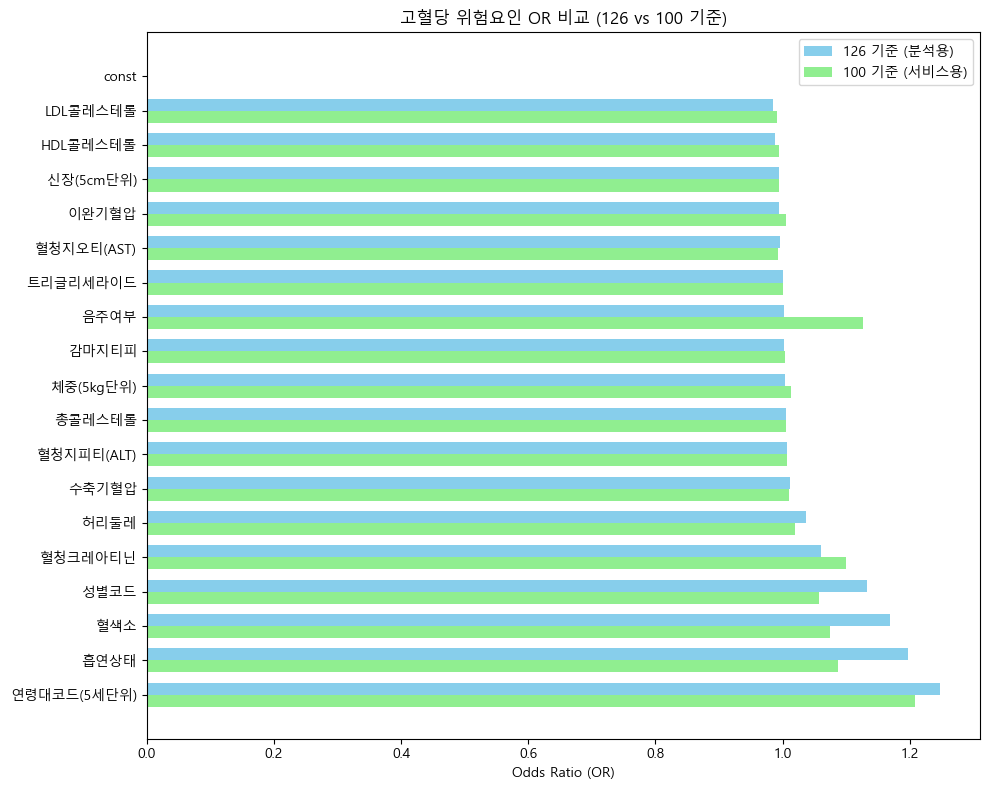

In [7]:
import matplotlib.pyplot as plt

# 두 결과 합치기 (126 vs 100 기준 비교)
merged = summary_126[['변수','OR (exp(β))']].merge(
    summary_100[['변수','OR (exp(β))']],
    on='변수',
    suffixes=('_126','_100')
)

# 정렬: 126 기준 OR 크기 순으로
merged = merged.sort_values('OR (exp(β))_126', ascending=False)

# 시각화
plt.figure(figsize=(10,8))
bar_width = 0.35
x = range(len(merged))

plt.barh([i+bar_width for i in x], merged['OR (exp(β))_126'], 
         height=bar_width, label='126 기준 (분석용)', color='skyblue')
plt.barh(x, merged['OR (exp(β))_100'], 
         height=bar_width, label='100 기준 (서비스용)', color='lightgreen')

plt.yticks([i+bar_width/2 for i in x], merged['변수'])
plt.xlabel("Odds Ratio (OR)")
plt.title("고혈당 위험요인 OR 비교 (126 vs 100 기준)")
plt.legend()
plt.tight_layout()
plt.show()

# ㅇㅇ

In [8]:
def calculate_risk(age_code=None, waist=None, sex=None,
                   ldl=None, tg=None, gtp=None, smoke=None,
                   hb=None, drink=None, survey_mode=False):
    """
    age_code: 5세 단위 연령코드 (예: 8=40대, 10=50대)
    waist: 허리둘레(cm)
    sex: 1=남, 2=여
    ldl: LDL 콜레스테롤
    tg: 트리글리세라이드
    gtp: 감마지티피
    smoke: 0=비흡연, 2=과거흡연, 3=현재흡연
    hb: 혈색소
    drink: 0=비음주, 1=음주
    survey_mode: True면 설문 모드(자가 응답 기반), False면 검진 데이터 기반
    """
    score = 0
    
    # ✅ 연령
    if age_code:
        if age_code >= 10: score += 2   # 50대 이상
        elif age_code >= 8: score += 1  # 40대

    # ✅ 허리둘레
    if waist and sex:
        if (sex == 1 and waist >= 90) or (sex == 2 and waist >= 85):
            score += 3

    # ✅ LDL
    if ldl:
        if ldl >= 160: score += 2
        elif ldl >= 130: score += 1
    elif survey_mode:  # 설문용: "기름진 음식 자주 먹는다" → LDL 고위험 가정
        score += 1

    # ✅ TG
    if tg:
        if tg >= 200: score += 2
        elif tg >= 150: score += 1
    elif survey_mode:  # 설문용: "단 음식/야식 자주" → TG 고위험 가정
        score += 1

    # ✅ 감마지티피
    if gtp:
        if gtp >= 70: score += 2
        elif gtp >= 40: score += 1
    elif survey_mode:  # 설문용: "술 자주 마심" → gtp 위험 반영
        score += 1

    # ✅ 흡연
    if smoke == 3: score += 2
    elif smoke == 2: score += 1

    # ✅ 혈색소
    if hb and sex:
        if (sex == 1 and hb > 17) or (sex == 2 and hb > 15.5):
            score += 1

    # ✅ 음주
    if drink == 1: score += 1

    # ✅ 위험 레벨
    if score >= 7:
        level = "위험"
    elif score >= 4:
        level = "경고"
    else:
        level = "주의"

    return score, level


In [10]:
survey_dict = {
    "version": "1.0",
    "title": "혈당 자가 위험도 테스트",
    "sections": [
        {
            "id": "basic",
            "title": "기본 정보",
            "fields": [
                {
                    "id": "age_code",
                    "label": "연령대",
                    "type": "select",
                    "options": [
                        {"label": "20-39세", "value": 6},
                        {"label": "40-49세", "value": 8},
                        {"label": "50세 이상", "value": 10}
                    ]
                },
                {
                    "id": "sex",
                    "label": "성별",
                    "type": "radio",
                    "options": [
                        {"label": "남성", "value": 1},
                        {"label": "여성", "value": 2}
                    ]
                },
                {
                    "id": "waist",
                    "label": "허리둘레(cm)",
                    "type": "number",
                    "optional": True
                }
            ]
        },
        {
            "id": "lifestyle",
            "title": "생활습관",
            "fields": [
                {
                    "id": "smoke",
                    "label": "흡연 여부",
                    "type": "radio",
                    "options": [
                        {"label": "비흡연", "value": 0},
                        {"label": "과거 흡연", "value": 2},
                        {"label": "현재 흡연", "value": 3}
                    ]
                },
                {
                    "id": "drink",
                    "label": "음주 여부",
                    "type": "radio",
                    "options": [
                        {"label": "아니오", "value": 0},
                        {"label": "예", "value": 1}
                    ]
                }
            ]
        },
        {
            "id": "lab",
            "title": "건강검진 수치 (선택 입력)",
            "fields": [
                {"id": "ldl", "label": "LDL 콜레스테롤 (mg/dL)", "type": "number", "optional": True},
                {"id": "tg", "label": "트리글리세라이드 (mg/dL)", "type": "number", "optional": True},
                {"id": "gtp", "label": "감마지티피 (U/L)", "type": "number", "optional": True},
                {"id": "hb", "label": "혈색소 (g/dL)", "type": "number", "optional": True}
            ]
        }
    ],
    "submit": {
        "label": "위험도 계산하기",
        "action": "/api/calculate_risk"
    }
}

# 테스트 출력
print(survey_dict["title"])
for sec in survey_dict["sections"]:
    print(f"- {sec['title']} ({len(sec['fields'])}개 질문)")

혈당 자가 위험도 테스트
- 기본 정보 (3개 질문)
- 생활습관 (2개 질문)
- 건강검진 수치 (선택 입력) (4개 질문)


In [11]:
import pandas as pd

# 위험 점수 계산 함수
def risk_score(row):
    score = 0
    
    # 연령
    if row['연령대코드(5세단위)'] >= 10:   # 50세 이상
        score += 2
    elif row['연령대코드(5세단위)'] >= 8:  # 40대
        score += 1

    # 허리둘레 (남 ≥90 / 여 ≥85 기준)
    if (row['성별코드'] == 1 and row['허리둘레'] >= 90) or (row['성별코드'] == 2 and row['허리둘레'] >= 85):
        score += 3

    # LDL 콜레스테롤
    if row['LDL콜레스테롤'] >= 160:
        score += 2
    elif row['LDL콜레스테롤'] >= 130:
        score += 1

    # 트리글리세라이드
    if row['트리글리세라이드'] >= 200:
        score += 2
    elif row['트리글리세라이드'] >= 150:
        score += 1

    # 감마지티피
    if row['감마지티피'] >= 70:
        score += 2
    elif row['감마지티피'] >= 40:
        score += 1

    # 흡연
    if row['흡연상태'] == 3.0:
        score += 2
    elif row['흡연상태'] == 2.0:
        score += 1

    # 혈색소
    if (row['성별코드'] == 1 and row['혈색소'] > 17) or (row['성별코드'] == 2 and row['혈색소'] > 15.5):
        score += 1

    # 음주
    if row['음주여부'] == 1.0:
        score += 1

    return score

# 위험 등급 분류
def risk_level(score):
    if score >= 7:
        return "위험"
    elif score >= 4:
        return "경고"
    else:
        return "주의"

# 적용
df['risk_score'] = df.apply(risk_score, axis=1)
df['risk_level'] = df['risk_score'].apply(risk_level)

print(df[['연령대코드(5세단위)','허리둘레','LDL콜레스테롤','트리글리세라이드','감마지티피','흡연상태','혈색소','음주여부','risk_score','risk_level']].head(20))


    연령대코드(5세단위)  허리둘레  LDL콜레스테롤  트리글리세라이드  감마지티피  흡연상태   혈색소  음주여부  \
0            13  70.0     113.0     105.0    6.0   1.0  14.7   1.0   
1            11  74.9     113.0     105.0   14.0   1.0  12.7   1.0   
2            13  74.0     113.0     105.0   17.0   1.0  13.7   1.0   
3            16  89.0     113.0     105.0   28.0   1.0  15.6   1.0   
4            11  76.0     113.0     105.0   12.0   1.0  14.8   1.0   
5            10  90.0     113.0     105.0   38.0   1.0  14.8   1.0   
6            11  78.0     113.0     105.0   40.0   1.0  15.1   1.0   
7             9  77.0     113.0     105.0   18.0   1.0  14.6   1.0   
8            10  82.5     113.0     105.0   37.0   1.0  15.9   1.0   
9            10  87.0     113.0     105.0   16.0   1.0  14.9   1.0   
10           13  87.0     113.0     105.0   24.0   1.0  15.5   0.0   
11            9  76.5     113.0     105.0   11.0   1.0  13.2   1.0   
12            7  70.4     113.0     105.0   10.0   1.0  13.0   0.0   
13            5  73.

In [16]:
# ---------------------------
# 0. X, y 정의
# ---------------------------
target = "고혈당_분석용"   # 126 기준 (분석용)
# target = "고혈당_서비스용"  # 100 기준 (서비스용) → 이 줄로 바꾸면 됨

# y = 타겟
y = df[target]

# X = 독립변수 (타겟, 식전혈당 제외)
exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)"]
X = df.drop(columns=exclude_cols, errors="ignore")

In [19]:
# ---------------------------
# 0. X, y 정의
# ---------------------------
target = "고혈당_분석용"   # or "고혈당_서비스용"
y = df[target]

# 모델 학습에서 제외할 컬럼
exclude_cols = [
    "고혈당_분석용", "고혈당_서비스용", "식전혈당(공복혈당)",
    "risk_level"  # 🚫 문자열 컬럼 제외
]

X = df.drop(columns=exclude_cols, errors="ignore")

# ---------------------------
# 1. 범주형 변수 처리 (원-핫 인코딩)
# ---------------------------
cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# ---------------------------
# 2. 모든 피처를 float32로 변환
# ---------------------------
X = X.astype("float32")
y = y.astype("int")

# ---------------------------
# 3. 데이터 분할
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 클래스 불균형 비율 계산
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")

# ---------------------------
# 4. XGBoost 학습
# ---------------------------
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)

# ---------------------------
# 5. 평가
# ---------------------------
print("📊 XGBoost (class weight 적용)")
print(classification_report(y_test, xgb_model.predict(X_test)))


scale_pos_weight = 11.76
📊 XGBoost (class weight 적용)
              precision    recall  f1-score   support

           0       0.97      0.69      0.81    184213
           1       0.18      0.79      0.29     15787

    accuracy                           0.70    200000
   macro avg       0.58      0.74      0.55    200000
weighted avg       0.91      0.70      0.77    200000



📊 변수 중요도 (XGBoost)
             변수    중요도(gain)
25   risk_score  1125.184082
2   연령대코드(5세단위)   647.318542
29     음주여부_1.0   486.763977
17          요단백   239.532654
5          허리둘레   210.922867
26       성별코드_2   194.604980
21        감마지티피   171.865433
15     LDL콜레스테롤   161.903244
20   혈청지피티(ALT)   129.434189
19   혈청지오티(AST)   125.716179
12       총콜레스테롤   121.539520
18      혈청크레아티닌   110.883232
16          혈색소    96.447632
7         시력(우)    85.975998
6         시력(좌)    80.277061
10        수축기혈압    79.446793
13     트리글리세라이드    78.637581
28     흡연상태_3.0    67.040977
23      치아우식증유무    64.382401
11        이완기혈압    55.289452


<Figure size 1000x600 with 0 Axes>

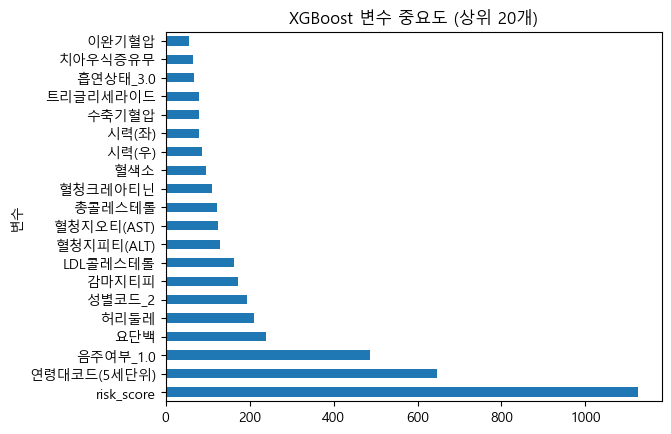

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# 변수 중요도 추출
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    '변수': list(importance.keys()),
    '중요도(gain)': list(importance.values())
}).sort_values(by='중요도(gain)', ascending=False)

print("📊 변수 중요도 (XGBoost)")
print(importance_df.head(20))

# 시각화
plt.figure(figsize=(10,6))
importance_df.head(20).plot(
    kind='barh', x='변수', y='중요도(gain)', legend=False
)
plt.title("XGBoost 변수 중요도 (상위 20개)")
plt.show()


In [22]:
# ---------------------------
# 0. X, y 정의
# ---------------------------
target = "고혈당_분석용"   # 126 기준 (분석용)
y = df[target]

# 제외할 컬럼 (risk_level은 모델에 안 씀)
exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

# ---------------------------
# 1. 범주형 변수 원-핫 인코딩
# ---------------------------
cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# ---------------------------
# 2. 데이터 분할
# ---------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 클래스 불균형 비율
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")

# ---------------------------
# 3. XGBoost 학습
# ---------------------------
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)

# ---------------------------
# 4. 평가
# ---------------------------
print("📊 XGBoost (class weight 적용)")
print(classification_report(y_test, xgb_model.predict(X_test)))


scale_pos_weight = 11.76
📊 XGBoost (class weight 적용)
              precision    recall  f1-score   support

           0       0.97      0.69      0.81    184213
           1       0.18      0.79      0.29     15787

    accuracy                           0.70    200000
   macro avg       0.58      0.74      0.55    200000
weighted avg       0.91      0.70      0.77    200000



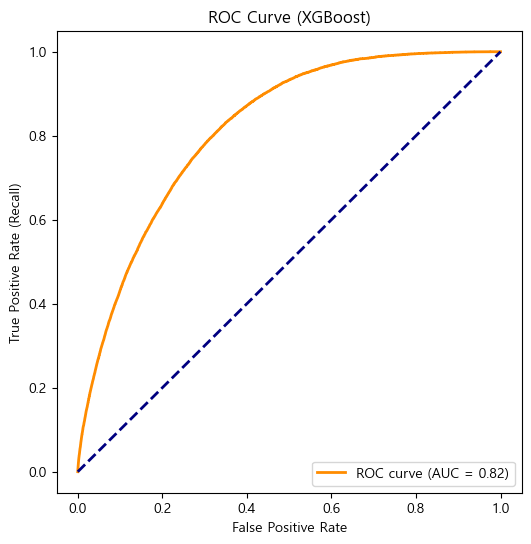

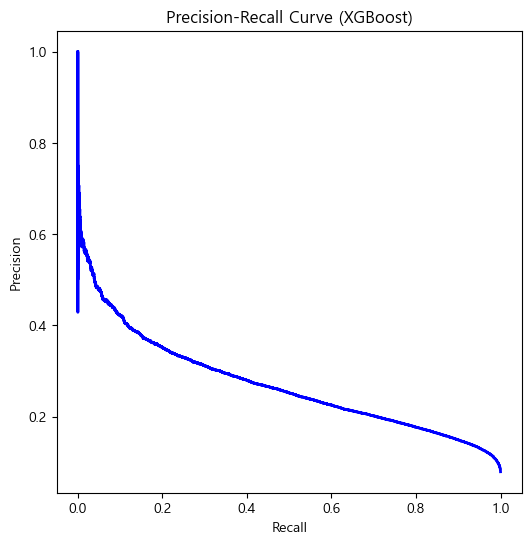

✅ 최적 Threshold = 0.69
Precision = 0.26, Recall = 0.47, F1 = 0.34


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ---------------------------
# 1. 예측 확률 얻기
# ---------------------------
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # 양성(1)일 확률

# ---------------------------
# 2. ROC Curve & AUC
# ---------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (XGBoost)")
plt.legend(loc="lower right")
plt.show()

# ---------------------------
# 3. Precision-Recall Curve
# ---------------------------
prec, rec, pr_thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='blue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()

# ---------------------------
# 4. 최적 threshold 찾기 (F1 score 기준)
# ---------------------------
f1_scores = 2 * (prec * rec) / (prec + rec)
best_idx = f1_scores.argmax()
best_threshold = pr_thresholds[best_idx]

print(f"✅ 최적 Threshold = {best_threshold:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")


scale_pos_weight = 11.76
ROC-AUC = 0.82


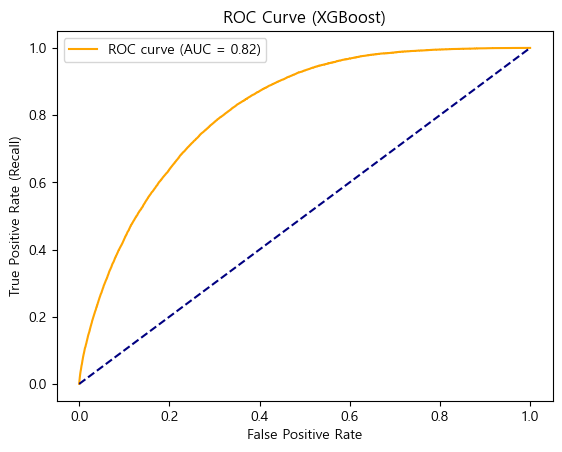

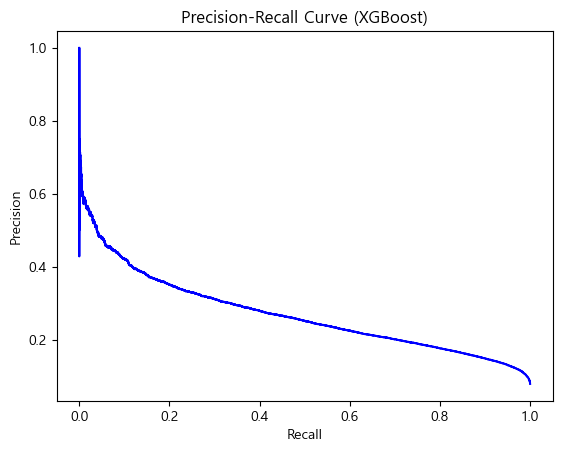

✅ 최적 Threshold = 0.69
📊 XGBoost (Threshold 조정)
              precision    recall  f1-score   support

           0       0.95      0.88      0.92    184213
           1       0.26      0.47      0.34     15787

    accuracy                           0.85    200000
   macro avg       0.61      0.68      0.63    200000
weighted avg       0.90      0.85      0.87    200000



In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ---------------------------
# 0. X, y 정의
# ---------------------------
target = "고혈당_분석용"   # 또는 "고혈당_서비스용"
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

# 범주형 변수 원-핫 인코딩
cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 타입 변환
X = X.astype("float32")
y = y.astype("int")

# ---------------------------
# 1. 데이터 분할
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")

# ---------------------------
# 2. XGBoost 학습
# ---------------------------
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)

# ---------------------------
# 3. ROC / PR 평가
# ---------------------------
y_pred_proba = xgb_model.predict_proba(X_test)[:,1]

# AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC = {auc:.2f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0,1],[0,1],"--",color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.show()

# PR curve
prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()

# ---------------------------
# 4. Threshold 튜닝
# ---------------------------
best_thresh = thresh[np.argmax(2*prec*rec/(prec+rec+1e-6))]  # F1 최대 기준
print(f"✅ 최적 Threshold = {best_thresh:.2f}")

# 최적 threshold 적용
y_pred_custom = (y_pred_proba >= best_thresh).astype(int)

print("📊 XGBoost (Threshold 조정)")
print(classification_report(y_test, y_pred_custom))
